# CS5914 Machine Learning Algorithms
## Assignment 2 
##### Credits: 35% of courework

## Aims

The objectives of this assignment are:

* deepen your understanding of Bayesian inference
* deepen your understanding of clustering and unsupervised learning
* gain experience in implementing sampling-based Bayesian inference algorithms
* gain experience in implementing clustering algorithms


## Set-up

Load required packages (you can only use the imported packages).

In [47]:
import numpy
# if you use jupyter-lab, switch to %matplotlib inline instead
%matplotlib inline
#%matplotlib notebook
%config Completer.use_jedi = False
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from scipy.special import logsumexp
import numpy.linalg as linalg
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score

In [48]:
# use fixed random number generator seed to have reproducible results
random_seed = 123
rng = np.random.default_rng(random_seed)

## Task 1. Spherical K-means

### Read-in datasets
We are going to use two datasets, `dataset1` and `dataset2`. Read in dataset1:
* ``dataset1``: 500 observations and each with 4 features
* note that no cluster labels given for this dataset

In [49]:
# read in dataset1
d1_df = pd.read_csv('./datasets/dataset1.csv', header=None)
dataset1 = np.array(d1_df)
# it should contain 500 observations and each with 4 dimensional input
n_dataset1, d_dataset1 = dataset1.shape

Read in dataset2, which contains 
* ``dataset2``: 500 observations; and each with 3000 features
* ``dataset2_labels``: the labels are listed in the last column; there are $K=4$ clusters

In [50]:
# read in dataset2
d2_df = pd.read_csv('./datasets/dataset2.csv', header=None)
dataset2, dataset2_labels = d2_df.iloc[:, 0:-1], d2_df.iloc[:, -1]
dataset2 = np.array(dataset2)
dataset2_labels = np.array(dataset2_labels).astype(int)
n_dataset2, d_dataset2 = dataset2.shape

A quick demonstration of clustering performance evaluation
* use Sklearn.KMeans to fit a basic clustering model and 
* evaluate the clustering performance against the true label with normalised mutual information (NMI)

In [51]:
# evaluate clustering performance by normalised mutual information.
# use Kmeans to learn the clusters: use the first four rows as centroids
km_dataset2 = KMeans(n_clusters=4, init=dataset2[0:4,:]).fit(dataset2)
# should expect approximately < 0.35 performance by using Kmeans
normalized_mutual_info_score(km_dataset2.labels_, dataset2_labels)

0.30872980833029307

### Spherical K-means
The first task is to implement a variant of K-means algorithm, which is called *Spherical K-means*. The algorithm follows a similar procedure as K-means but with slightly different assignment and update steps. In the following, we will explain the spherical K-means algorithm. 


**Initialisation step**: Start with randomly selecting $K$ data points as the centroid of $K$ clusters. 

**Assignment step**: *Spherical K-means* assigns a data point to the closest centroid based on *cosine distance* rather than Euclidean distance; specifically, for $i=1,\ldots, n$

$$z^{(i)} \leftarrow \arg\min_{k} \left (1- \frac{\boldsymbol{\mu}_k^\top \mathbf{x}^{(i)} }{\|\boldsymbol{\mu}_k\| \cdot \|\mathbf{x}^{(i)}\|}\right ),$$ where $\boldsymbol{\mu}_k^\top \mathbf{x}^{(i)} = \sum_{j=1}^d \boldsymbol{\mu}_{kj} \cdot \mathbf{x}^{(i)}_{j}$ denotes the inner product and $\|\mathbf{x}\|$ is $L_2$ norm of a vector $\mathbf{x}$: $\|\mathbf{x}\| = \sqrt{\mathbf{x}^\top \mathbf{x}}$.

**Update step**: *Spherical K-means* updates the centroids such that they are unit one vectors; for $k=1,\ldots, K$

$$\boldsymbol{\mu}_k \leftarrow \frac{\sum_{i=1}^n I(z^{(i)} =k) \cdot  \mathbf{x}^{(i)}}{\|\sum_{i=1}^n I(z^{(i)} =k) \cdot \mathbf{x}^{(i)}\|}.$$ Note that after the normalisation step, the centroids $\boldsymbol{\mu}_k$ are norm-one vectors: i.e. $\|\boldsymbol{\mu}_k\| = 1$ for $k=1,\ldots, K$.

**Repeat** the above two steps **until** the total cosine distance loss converges, where the loss is defined as
$$\texttt{loss} = \sum_{i=1}^n \left (1- \frac{\boldsymbol{\mu}_{z^{(i)}}^\top \mathbf{x}^{(i)} }{\|\boldsymbol{\mu}_{z^{(i)}}\| \cdot \|\mathbf{x}^{(i)}\|}\right ).$$



#### Task 1.1 Implementation of Spherical K-means

Your task is to complete the code for *assignment* and *update* steps at the given code template of `sphericalKmeans`.

The method `sphericalKmeans` has

**Inputs**:
* `data`: a $n\times d$ matrix to cluster, i.e. each row of $\texttt{data}$ is one observation $x_i$
* `K`: the number of the clusters
* `tol`: tolerence of error, which is used to check whether the loss has converged so the iteration can stop
* `maxIters`: the maximum number of iterations that is allowed

**Outputs**:
* `losses`: the whole trajectory of losses over the iterations
* `zs`: the clustering labels
* `us`: the learnt $K$ centroids

Feel free to write extra helper methods to make your implementation modularised. You may also rewrite the method altogether as long as your method respect the given mtehod's input/output signature. 

In [52]:

def random_centroid_sel(data = d1_df, k_size=0):
    """
    Handles the random assignment of centroid points within a clustering dataset
    :param data: the dataset to use
    :param k_size: the cluster size
    :return: a subset of randomly assigned centroid points
    """
    
    return data.sample(n=k_size).to_numpy()

def l2_norm(x):
    """
    Calculates the L2 Normalisation process 
    :param x: the value to be normalised
    :return: the square root of product calaculations
    """
    return np.linalg.norm(x)

def inner_prod(u, x):
    """
    Calcultes the inner product of a value
    :param u: the current selected centroid
    :param x: the matrix of all points
    :return: the sum of all product calculations
    """
    return np.sum(x@u)

def sqr_prod(u, x):
    """
    Calculates the dot product of normalised centroid and X 
    :param u: the centroid selected
    :param x: list of all X values
    :return: Calculated dot product of these two values
    """
    u_val = l2_norm(u)
    x_val = l2_norm(x)
    return np.dot(x_val,u_val)

def diff_calc(u, x):
    """
    Calculates the log difference of centroid to X 
    :param u: 
    :param x: 
    :return: 
    """
    norm_mu_k = l2_norm(u)
    norm_x_i = l2_norm(x)
    return 1 - (inner_prod(u, x)/(norm_mu_k*norm_x_i))#sqr_prod(u, x))

def assignment_step(u, x): 
    """
    Calculates where the closest centroid is for each X item
    :param u: the centroids to check
    :param x: the list of X items
    :return: a list of closest centroid indexes are 
    """
    cos_dis = np.hsplit(np.hstack([[diff_calc(u[k],x_item) for k in range(0, u.shape[0]-1)] for x_item in x]), x.shape[0])
    zs = np.argmin(cos_dis, axis=1)
   
    return zs

def update_step(z, x, k):
    """
    Function carrys out update of centroids
    :param z: list of indexes
    :param x: the list of x items
    :param k: number of centroids
    :return: updated centroids with row length of k and column size matches x
    """
    updated_zs = np.empty([k, x.shape[1]])
    for i in range(0, k-1):
        z_i = (z==i).astype(int)
        in_prod = np.sum(x[z_i==1], axis=0)
        norm = l2_norm(in_prod)
        val= in_prod / norm if norm !=0 else 0
        updated_zs[i]= val
    return updated_zs


    

def loss_calc(u, x, z): 
    """
    Calculates the loss between the custer groups
    :param theta: centroids
    :param x: the test case by group
    :return: the loss on the current run 
    """
    diff =0
    uk_z = np.array([u[i] for i in z])
    diff= [diff_calc(uk_z[i], x[i]) for i in range(0, len(uk_z)-1)]
    results = np.sum(diff)
    return results


def sphericalKmeans(data, K=3, tol= 1e-3, maxIters= 100):
    """
    Function calculates the K means of the provided data
    :param data: data to calculate in dataset form 
    :param K: number of centroids to create
    :param tol: the tolarated difference allowance
    :param maxIters: max number of runs of calculations
    :return: list of losses, 
    """
    n, d = data.shape
    #centroids = 
    losses = []
    # initialisation: randomly assign K observations as centroids
    # feel free to use a different but sensible initialisation method    
    init_us_ids = rng.integers(n, size = K)
    us = data[init_us_ids, :]
    #us = random_centroid_sel(data, K)
    zs = np.zeros(n)
    # loop until converge 
    for i in range(maxIters):
        # assignment step
        z = assignment_step(us, data)
        # update step
        uk = update_step(z, data, K)
        # convergence check
        loss_tot = loss_calc(uk, data, z)
        if i>0:
             loss_diff= loss_tot-losses[-1]
             if abs(loss_diff) < tol:
                return losses, zs, us
        zs =z
        losses.append(loss_tot)
        us= uk
        
    return losses, zs, us
    


 #### Task 1.2 Evaluation

Run your implemented algorithm on `dataset1` with $K =3$. Note that like K-means, Spherical K-means also suffers from bad initialisations. To deal with that, we usually run the algorithm multiple times with different random initialisations. To make your life easier, you may want to write a wrapper method that does it automatically.

Please report the following information based on your results: 
* the learned 3 centroids
* and also plot the loss trajectory.

If you run multiple times, you only need to report the results for the best one.

Centroids are: [[-6.70607735e-001  2.26296517e-001 -6.70151053e-001  2.23545786e-001]
 [-8.25358484e-002  7.08967311e-001 -1.24101654e-001  6.89312676e-001]
 [ 1.00552394e-047  3.69867592e-033  6.48224660e+170  4.93432906e+257]]
[49.926470028224685, 49.0494347988208, 48.94401003546081, 48.89403000670207, 48.878543287779024, 48.86029581163008, 48.85214516711436]


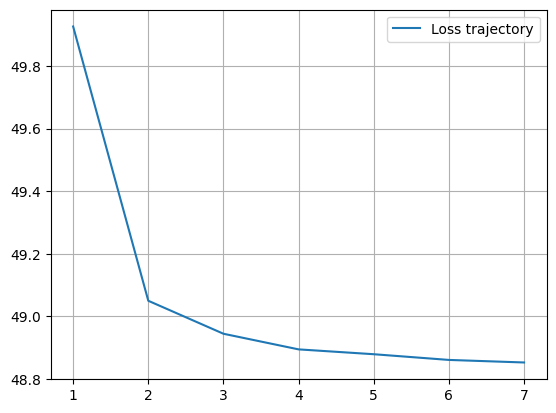

In [53]:
# run spherical K-means on dataset1 and report your results here
# use more cells if you need to


def run_k_means_iter(iterations, data, k=3, labels=None):
    """
    Runs K means and returns the best outcome of iterations 
    :param iterations: The number of iterations to run 
    :param data: the data to run the model 
    :param k: the number of centroids you want
    :return: The best run's centroids, losses, and the mapping of each entry to its closest centroid
    """

    mutual_score_list = np.empty(iterations, dtype=object)
    losses_list = np.empty(iterations, dtype=object)
    zs_list = np.empty(iterations, dtype=object)
    centroids_list = np.empty(iterations, dtype=object)
    for i in range(0, iterations):
        losses, zs, centroids =sphericalKmeans(data,k)
        losses_list[i]= losses
        zs_list[i] = zs
        centroids_list[i]= centroids
        if labels is not None: 
            mutual_score_list[i] = normalized_mutual_info_score(zs, labels)
            
    best_ind =  np.argmin(losses_list, axis=0) if labels is None else np.argmax(mutual_score_list, axis=0)
    return centroids_list[best_ind], losses_list[best_ind], zs_list[best_ind], mutual_score_list[best_ind]


centroid, loss,_,_= run_k_means_iter(10,dataset1, 3)

print("Centroids are: " + str(centroid))
print(loss)
plt.close()
plt.plot(range(1, len(loss)+1), loss, label = 'Loss trajectory')
plt.grid()
plt.legend()
plt.show()


\Now run your implemented algorithm on `dataset2` with $K =4$. And report the normalised mutual information between the returned cluster labels and true labels.

In [54]:
# run spherical K-means on dataset2 and report your NMI results here
# use more cells if you need to
centroid_2, loss_2, _, mutual_score= run_k_means_iter(20, dataset2, 4, dataset2_labels)
print("Best Mutual Score is"+ str(mutual_score))
print("Centroids are: "+ str(centroid_2))


Best Mutual Score is0.42390315403521267
Centroids are: [[-0.01154546 -0.01258547 -0.0022079  ... -0.0050615   0.00733877
   0.02212049]
 [ 0.00821964 -0.00349751 -0.03019873 ... -0.00407503 -0.00135599
   0.00010473]
 [-0.00728558  0.01150455  0.00161807 ...  0.0121088   0.00740512
   0.02061775]
 [-0.03962174  0.00693361 -0.00272726 ... -0.01684066  0.0118298
  -0.03217161]]


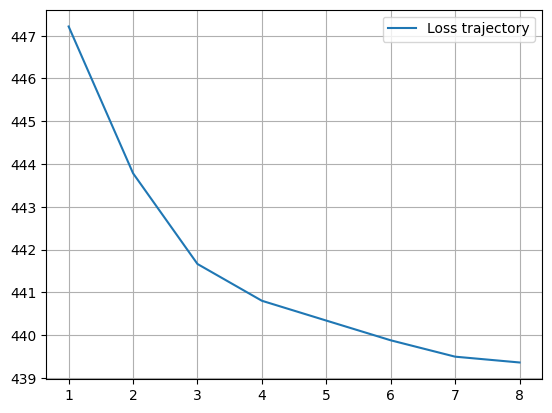

In [55]:
plt.close()
plt.plot(range(1, len(loss_2)+1), loss_2,  label = 'Loss trajectory')
plt.grid()
plt.legend()
plt.show()


## Task 2. Bayesian Machine Learning


In this task, we are going to implement a simple MCMC algorithm to do Bayesian logistic regression. You will be guided to finish the task step by step. First, we read-in the dataset required for the task.

### Dataset
We are going to use the following simple dataset for this task. The dataset is read-in below and stored in variables `XX` and `yy`. There are in total 16 training instances.


In [56]:
d3_df = pd.read_csv('./datasets/dataset3.csv', header=0)
dataset3 = d3_df.to_numpy()
XX, yy = dataset3[:, 0:2], dataset3[:, -1]
XX = np.column_stack((np.ones(XX.shape[0]), XX)) #Note to self: Stop removing this, this is the bias param

### Task 2.1

The log-likelihood for the probabilistic logistic regression is defined as 

$$p(y^{(i)}|\mathbf{w}, \mathbf{x}^{(i)}) = (\sigma^{(i)})^{y^{(i)}}(1-\sigma^{(i)})^{1-y^{(i)}},$$

where $\sigma^{(i)}(\mathbf{x}, \mathbf{w}) = \frac{1}{1+e^{-\mathbf{w}^\top\mathbf{x}}}$ is the logistic regression's output. For simplicity, we assume the feature $\mathbf{x}$ vector includes dummy one and the weight parameter includes the bias.

Give the expression for the joint log-likelihood $\ln p(\{y^{(i)}\}|\mathbf{w}, \mathbf{X})$ for the probabilistic model, where $\mathbf{X}$ is the design matrix ($\mathbf{X} = \begin{bmatrix}\mathbf{x}^{(1)}& \mathbf{x}^{(2)} & \ldots & \mathbf{x}^{(n)}\end{bmatrix}^\top$). 

#### Answer:

 $\ln p(\{y^{(i)}\}|\mathbf{w}, \mathbf{X})= y \log(\sigma) + ((1-y) \log(1- \sigma))$

#### Implement the joint likelihood method below:

In [57]:
def sigma(w, x):
    """
    Function handles the log calculation 
    :param w: The weights to use in calculation 
    :param x: The x values to use in calculation 
    :return: A log value for all supplied X vals
    """
    return 1 / (1+ np.exp(-np.dot(x, w.T)))

def log_likelihood(w, X=XX, y=yy):
    """
    Calculates the log likelihood of the model
    :param w: The model weights
    :param X: The training data
    :param y: The training / test results
    :return: the log likelihood findings for the data provided
    """
    
    results = [single_entry_likelihood(y[i], w, X[i]) for i in range(y.shape[0])]
    return np.sum(results)

def dot_calc(w, x):
    """
    Calculates the dot product of weights and the input data
    :param w: the weights
    :param x: the input data
    :return: either a scalar or column vector of results
    """
    return w.T@x

def single_entry_likelihood(y, w, x):
    """
    Calculates the logistic regression results for input data based on weights
    :param y: single y row data 
    :param w: The weights
    :param x: Single x row data
    :return: result of single_entry_likelihood as scalar
    """
    sigma_cacl = sigma(w, x)
    if(sigma_cacl== 0):
        sigma_cacl = 1e-16
    if(sigma_cacl==1):
        sigma_cacl = 1-1e-16
        
    return y * np.log(sigma_cacl) + (1 - y) * np.log(1 - sigma_cacl)

### Task 2.2

A Bayesian logistic regression model usually assumes a zero mean Gaussian prior for the weight parameter $\mathbf{w}$:

$$p(\mathbf{w}|\lambda) = \mathcal{N}_m\left(\mathbf{w}; \mathbf{0}, \frac{1}{\lambda}\mathbf{I}\right)=\prod_{d=1}^m \mathcal{N}(w_d; 0, 1/\lambda)$$

* where $\mathcal{N}_m$ denotes a $m-$dimensional Gaussian distribution and where $\lambda$ is the precision parameter of the Gaussian.

#### Write down an expression for the log-transformed prior $\ln p(\mathbf{w}|\lambda)$

#### Answer:
$$ln(p(\mathbf{w}|\lambda)) = - (\frac{1}{2} \log(2\pi)) - (\frac{1}{2} n * \log(\lambda)) - (\frac{1}{2} \lambda W^{T}W) $$

In [58]:
def prior(w, lam): 
    """
    Prior calculation interpretation as per the transformed formulae 
    :param w: The weights to use 
    :param lam: Lambda value provided
    :return: A calculated posterior, given the weights and lambda
    """
    gaus_dist = len(w)
    return -0.5 * gaus_dist * np.log(2 * np.pi) - 0.5 * gaus_dist * np.log(lam) - 0.5 * lam * np.dot(w, w)
  

### Task 2.3

Based on Bayes' rule, the unnormalised log posterior distribution is defined as

$$\ln p(\mathbf{w}|\{y^{(i)}\}, \mathbf{X}) = \ln p(\mathbf{w}|\lambda) + \ln p(\{y^{(i)}\}|\mathbf{X}, \mathbf{w})$$

#### Write down an expression for the unnormalised log-transformed posterior:

#### Answer:
      $$ ln p(w|{y^{(i)}, X})=  \frac{\lambda}{2} \sum_{d=1}^m w_d^{2}  + \frac{1}{2} \sum_{i=1}^n (y^{(i)} - W^{T}x^{i})^2 $$

#### Implement the unnormalised log posterior below:

In [59]:
def log_posterior(w, X=XX, y=yy, lambda0=1e-2):
    """
    Un-normalised posterior calculation 
    :param w: The weights to use in calculations
    :param X: The test set of data
    :param y: the test labels (or actual results)
    :param lambda0: The lambda value for the calculation
    :return: Combined likelihood and prior calculation 
    """
    prior_res = prior(w, lambda0)
    likelihood_res = log_likelihood(w, X, y)
    return likelihood_res + prior_res

 #### Report the unnormalised log posterior value at $\mathbf{w} =\mathbf{0}$ and $\lambda = \frac{1}{100}$

In [60]:
log_posterior(np.zeros(XX.shape[1]), XX, yy, lambda0=1e-2)

-6.939415209591006

### Task 2.4

Implement a **Metropolis sampling** algorithm to draw samples from the unnormalised posterior:

$$\mathbf{w}^{(m)} \sim p(\mathbf{w}|\{y^{(i)}\},\mathbf{X}),\;\; \text{for }m = 1, \ldots, M$$

You should use the following proposal distribution

$$q(\mathbf{w}'|\mathbf{w}) = \mathcal{N}\left (\mathbf{w}, \left(\lambda \mathbf{I} + \frac{6}{\pi^2} \mathbf X^\top \mathbf X\right)^{-1}\right),$$

You should convince yourself that the proposal distribution is symmetric. To draw random samples from multivariate Gaussian distribution, you may use `rng.multivariate_normal(mean, cov, size=800)`, where `mean` and `cov` are the corresponding mean and covariance parameters.

In [61]:
def proposal_dist(lambda_val, I, X): 
    """
    Python interpretation of the above suggested proposal distribution
    :param lambda_val: The lambda variable used in this calculation
    :param I: The identity matrix involved in this process
    :param X: The training data
    :return: a calculate proposal distribution
    """
    calc_1 = (lambda_val*I)
    calc_2 = ((6/np.pi**2)*(np.dot(X.T,X)))
    calc_3 = calc_1+calc_2
    return np.linalg.inv(calc_3)

def general_metro_progression(funct_for_pos, funct_for_alt_post, X, y, lambda0, covar, iters, cur_best):
    """
    General function for metropolis (sampling or hastings) calculations
    :param funct_for_pos: The function that is used to calculate the proposed posterior
    :param funct_for_alt_post: The function that is used to calculate the current posterior
    :param X: Training data
    :param y: Training labels
    :param lambda0: lambda variable 
    :param covar: Covariance calculations
    :param iters: Number of iterations to carry out
    :param cur_best: Current best weights 
    :return: Weight samples
    """
    _, cols= X.shape
    w_samples = np.zeros([iters, cols])
    for j in range(1,iters):
        prop_w = rng.multivariate_normal(cur_best, covar)
        pos_cur = funct_for_pos(prop_w, X, y, lambda0)
        best_score = funct_for_alt_post(cur_best, X, y, lambda0)
        score = pos_cur / best_score
        if rng.uniform(0, 1) < np.exp(pos_cur - best_score):
            w_samples[j] = prop_w
            cur_best = prop_w    
        else: 
             w_samples[j] = cur_best
    
    return w_samples
    
def metropolis_bayes_logistic_reg(X=XX, y=yy, lambda0=1e-2, mc=5000, burnin=1000):
    """
    
    :param X: Training data
    :param y: Training labels
    :param lambda0: lambda variable
    :param mc: Monte Carlo number value
    :param burnin: The number of burnin iterations you wish to do before recording the weights
    :return: The weighted samples 
    """
    _, cols= X.shape
    I = get_identity_matrix(X)
    current_best =np.zeros(cols)
    covariance = proposal_dist(lambda0, I ,X)
    w_samples = general_metro_progression(log_posterior, log_posterior, X, y, lambda0, covariance, burnin+mc, current_best)
    return w_samples[burnin:burnin+mc]

def get_identity_matrix(X): 
    """
    Function to retrieve identity matrix for training data
    :param X: The training data
    :return: The identity matrix based on training data 
    """
    row, cols= X.shape
    return np.eye(cols)

##### Implement a Monte Carlo prediction method and use the method to replicate the following decision boundary plot. Note that the Monte Carlo prediction is defined as:

$$p(y_{test}|\mathbf{x}_{test}) \approx \frac{1}{M} \sum_{m=1}^M \sigma(\mathbf{x}_{test}, \mathbf{w}^{(m)})$$

You only need roughly $M=1000$ Monte Carlo samples to make accurate predictions.

##### Explain why the Bayesian prediction should be preferred in comparison with the frequentist's MAP/ML estimation.

##### Answer: 
    The nature of MAP/ML estimation in prediction models have drawbacks that impact the accuracy of their predictions. 
    The first MLE is prone to overestimation, where the calculation can also favor those with high likelihood of a particular outcome. MAP, though
    slightly less biased in favor of likelihood, still has this issue. Both models do not factor in outliers due to its linear probability calculations, 
    where probabilities of a particular case or classsification (despite the fact that they may be close to a decision boundary) mean that they may 
    overcopensate for a particular case. Bayesian prediction mitigate though a more more detailed process that (if done correctly) result in a more 
    accurate, thorough, and variable prediction. 

In [62]:
def prediction_mc(xtest, w_samples):
    """
    Predicts the results of a set of test cases based on MCMC prediction
    :param xtest: The X value test cases
    :param w_samples: The weighted samples to predict against
    :return: MC sampled prediction 
    """
    M = len(w_samples)
    length, _ = xtest.shape
    results = np.zeros(length)
    
    for i in range(len(w_samples)): 
        results+= sigma(w_samples[i], xtest) 
    return results/M



<Figure size 640x480 with 0 Axes>

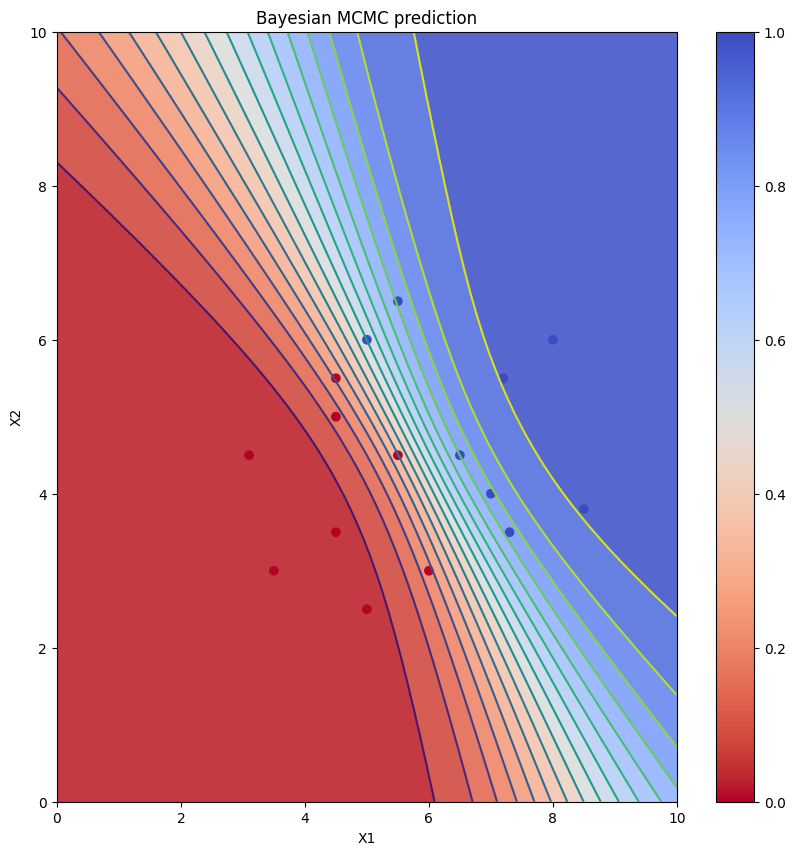

In [75]:
w= metropolis_bayes_logistic_reg(mc=900, burnin=1000)
results= prediction_mc(XX, w)


def plot_intensity_graph(x_vals,y,w_samp):
    """
    Draws an intensity graph based on the supplied X, Y, and weighted samples provided
    :param x_vals: The test data values 
    :param y: The test samples
    :param w_samp: The weights calculated from metropolis (sample or hastings) bayes logistic reg
    """
    x_min, x_max = x_vals[:, 0].min() - 1, x_vals[:, 0].max() + 1
    y_min, y_max = x_vals[:, 1].min() - 1, x_vals[:, 1].max() + 1

    x_mesh, y_mesh = np.meshgrid(np.linspace(0, 10, 100),
                                 np.linspace(0, 10, 100))
    plt.clf()
    plt.figure(figsize=(10, 10))
    grid_points = np.c_[np.ones(x_mesh.ravel().shape), x_mesh.ravel(), y_mesh.ravel()]
    z_val = prediction_mc(grid_points, w_samp)
    z_val = z_val.reshape(x_mesh.shape)
    plt.contourf(x_mesh, y_mesh, z_val, levels=16, cmap='coolwarm_r', alpha=0.9)
    plt.contour(x_mesh, y_mesh, z_val, levels=16, alpha=1)
    plt.scatter(x_vals[:, 1], x_vals[:, 2], c=y, cmap='coolwarm_r')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title('Bayesian MCMC prediction')
    plt.colorbar()
    plt.show()


plot_intensity_graph(XX, yy, w)

 ![Image of Yaktocat](https://leo.host.cs.st-andrews.ac.uk/figs/bayesian_preds.svg);

### Task 2.5 (extension)

Lastly, implement a **Metropolis-Hasting sampling** algorithm to draw samples from the unnormalised posterior:

$$\mathbf{w}^{(m)} \sim p(\mathbf{w}|\{y^{(i)}\},\mathbf{X}),\;\; \text{for }m = 1, \ldots, M$$

You should use the following proposal distribution

$$q(\mathbf{w}') = \mathcal{N}\left (\mathbf{w}_{MAP}, \left(10^2 \cdot \mathbf{I} + \frac{6}{\pi^2} \mathbf X^\top \mathbf X\right)^{-1}\right),$$

* where $\mathbf{w}_{MAP}$ is the maximum aposteriori estimator (MAP), which can be estimated by gradient descent. Note that the proposal is no longer symmetric, therefore you need to use the Metropolis Hasting algorithm instead.

C:\Users\RRHMc\AppData\Local\Temp\ipykernel_41328\1466348061.py:8: RuntimeWarning: overflow encountered in exp
  return 1 / (1+ np.exp(-np.dot(x, w.T)))


<Figure size 640x480 with 0 Axes>

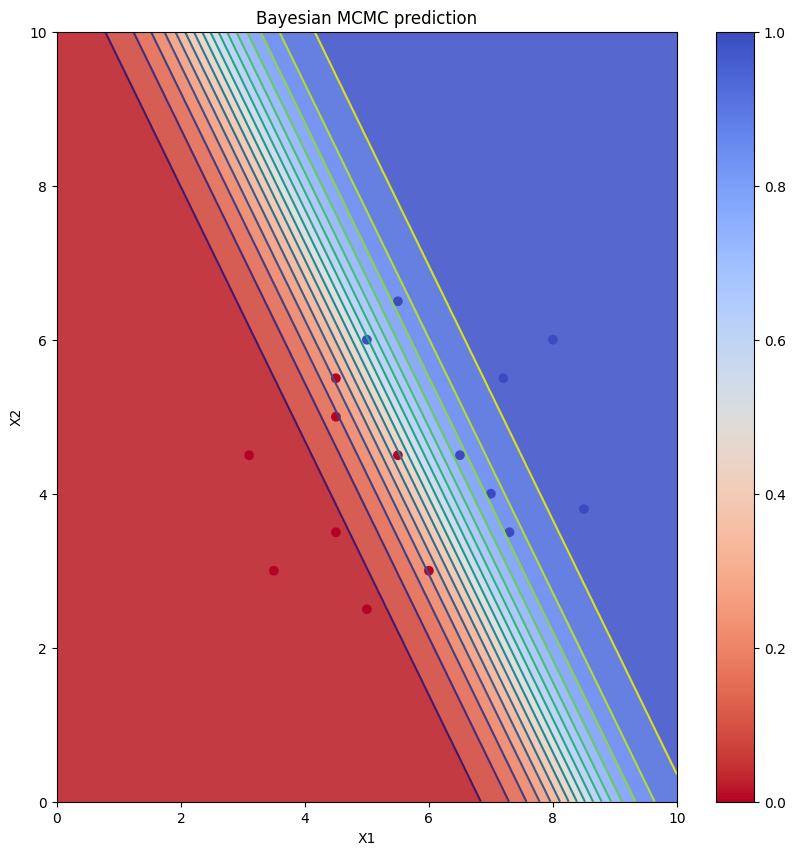

In [64]:
def metropolis_hasting_bayes_logistic_reg(X=XX, y=yy, lambda0=1e-2, mc=5000, burnin=1000):
    """
    Calculates weighted samples based on metropolis hastings algorithm
    :param X: The training data 
    :param y: Training labels 
    :param lambda0: The lambda variable
    :param mc: Monte Carlo sample count 
    :param burnin: the burn in count
    :return: Weighted samples which make up prediction model
    """
    _, cols= X.shape
    I = get_identity_matrix(X)
    current_best =gradient_descent(X, y, lambda0)
    covariance = metro_hayes_distro(I ,X)
    w_samples = general_metro_progression(log_posterior, log_posterior, X, y, lambda0, covariance, burnin+mc, current_best)
    return w_samples[burnin:burnin+mc]
    



def gradient_log_posterior(w, X, y, lambda0):
    """
    Calculates the gradient posterior 
    :param w: The weights 
    :param X: Training Data 
    :param y: Training labels 
    :param lambda0: Lambda value 
    :return: The combined gradient prior and likelihood 
    """
    log_calc = sigma(w, X)
    grad_log_likelihood = np.dot(X.T, y - log_calc)
    grad_log_prior = -lambda0 * w
    return grad_log_likelihood + grad_log_prior

def gradient_descent(X, y, lambda0, lr=0.01, iter=6000):
    """
    Calculates the gradient for the model
    :param X: The training data
    :param y: Training labels
    :param lambda0: The lambda value
    :param lr: Learning rate 
    :param iter: Number of iterations 
    :return: 
    """
    n_features = X.shape[1]
    w = np.zeros(n_features)
    for iteration in range(iter):
        grad = gradient_log_posterior(w, X, y, lambda0)
        w += lr * grad
        if np.linalg.norm(grad) < 1e-6:
            break
    return w


def metro_hayes_distro(I, X): 
    """
    Calculates the distribution proposal for Metropolis Hayes sampling 
    :param I: The identity matrix for data
    :param X: The training data
    :return: Distribution proposal 
    """
    
    dot_prod = X.T@X
    calc1 = (6/np.pi**2)*dot_prod
    calc2 = (10**2)*I
    calc3 = calc2+calc1
    return calc3

metro_hast_weights = metropolis_hasting_bayes_logistic_reg()
mc_metro_hast= prediction_mc(XX, metro_hast_weights)
plot_intensity_graph(XX, yy, metro_hast_weights)

Reuse the prediction method above to replicate the prediction plot.

## Submission
Hand in via Moodle: the completed jupyter notebook.



## Marking
Your submission will be marked as a whole. 

* to get a grade above 13, you are expected to finish at least Task 1 to a good standard
* to get a grade above 13 and up to 17, you are expected to answer Task 1 and Task 2.1-2.3 to a good standard
* to achieve a grade of 17-18, you are expected to finish all tasks except Task 2.5 flawlessly 
* to get 18+, you are expected to attempt all questions flawlessly


Marking is according to the standard mark descriptors published in the Student Handbook at:

https://info.cs.st-andrews.ac.uk/student-handbook/learning-teaching/feedback.html#GeneralMarkDescriptors


You must reference any external sources used. Guidelines for good academic practice are outlined in the student handbook at https://info.cs.st-andrews.ac.uk/student-handbook/academic/gap.html


## Submission dates
There are no fixed submission dates. Formal exam boards are held in January, May and September. Any provisional grades recorded on MMS are discussed by the Programme team and the External Examiner. Credits for a module can only be obtained after all the coursework has been discussed at an exam board, so students must submit work at least three weeks before the board date, giving time for grading and preparation of feedback.

https://www.st-andrews.ac.uk/education/staff/assessment/reporting/